In [10]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
sns.set()

from collections import OrderedDict

# Preprocessing
from sklearn.preprocessing import QuantileTransformer
# Algorithms
from tslearn.clustering import TimeSeriesKMeans
from tools import *

DATA_DIR = Path('../../data')
PROC_DIR = Path(DATA_DIR / 'processed')

OUT_DIR = Path('./out/tskmeans')
if not OUT_DIR.exists():
    OUT_DIR.mkdir(parents=True)

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']
MAX_CLUSTERS = 13

# Load data

In [11]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, skiprows=2, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])

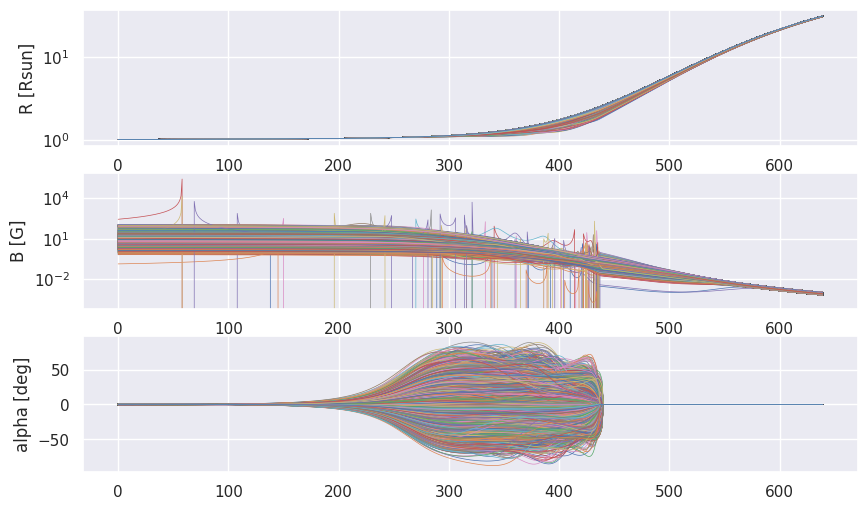

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(10, 6))
for idx, col in enumerate(flow_columns):
    for series in flows_dict.values():
        axs[idx].plot(series.index, series[col], linewidth=0.5)
        
axs[0].set_ylabel('R [Rsun]')
axs[1].set_ylabel('B [G]')
axs[2].set_ylabel('alpha [deg]')

axs[0].set_yscale('log')
axs[1].set_yscale('log')
# axs[2].set_yscale('symlog')


## Scale Inputs

In [13]:
scaled_flows = pd.DataFrame()
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='uniform')


scaled_flows = list(flows_dict.values())
scaled_flows = pd.concat(scaled_flows, axis=0)

scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)

scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())

(7533440, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.907467     0.239133
1  0.002002  0.907427     0.239333
2  0.003771  0.907386     0.239588
3  0.005826  0.907346     0.239846
4  0.007007  0.907306     0.240110


# Magnetic Field - B [G]

In [14]:
# separate into file series
scaled_magnetic = [scaled_flows['B [G]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['B [G]']) // 640)]
scaled_magnetic = np.array(scaled_magnetic)
scaled_magnetic[0][:5]


array([0.90746707, 0.9074268 , 0.90738646, 0.90734603, 0.90730552])

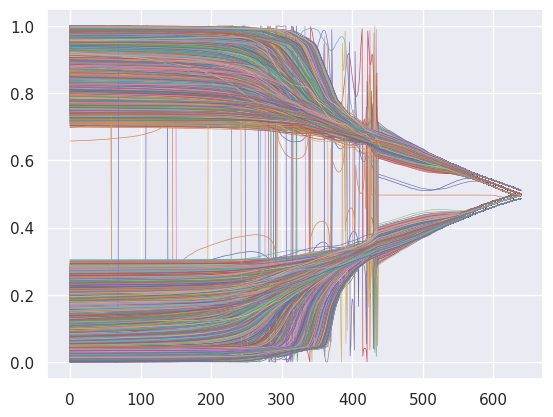

In [15]:
# plot scaled magnetic field
for b_line in scaled_magnetic:
    plt.plot(b_line, linewidth=0.5)

plt.yscale('linear')

## Time Series K-Means

In [16]:
# rule of thumb number of clusters 
cluster_count = math.ceil(6) 
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="euclidean", max_iter=100, random_state=0)

mag_labels = km.fit_predict(scaled_magnetic)

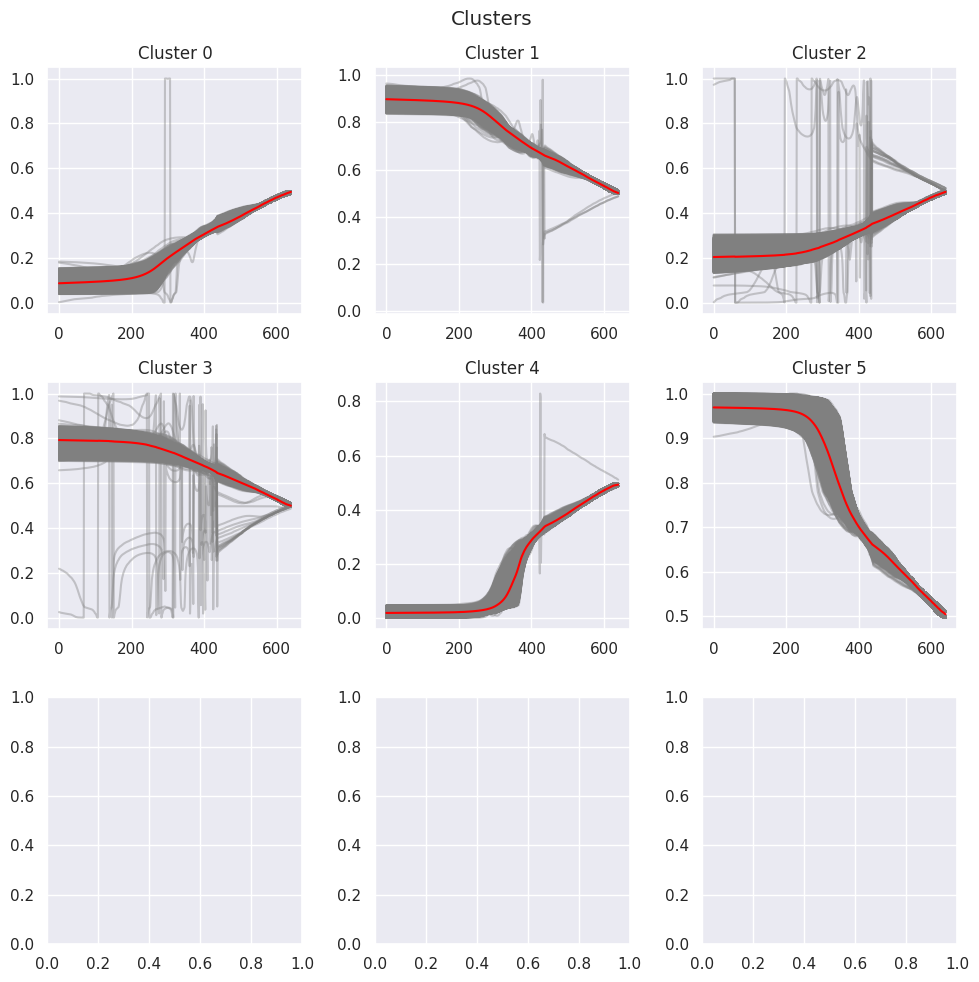

In [17]:
plot_km_results(cluster_count, mag_labels, scaled_magnetic)

### Original data clusters

/home/ivsaav/Projects/solarGAN/clustering/notebooks/tools.py:48: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[(labels[idx], col_pos)].set(ylabel=col, yscale=yscale.get(col, 'linear'))


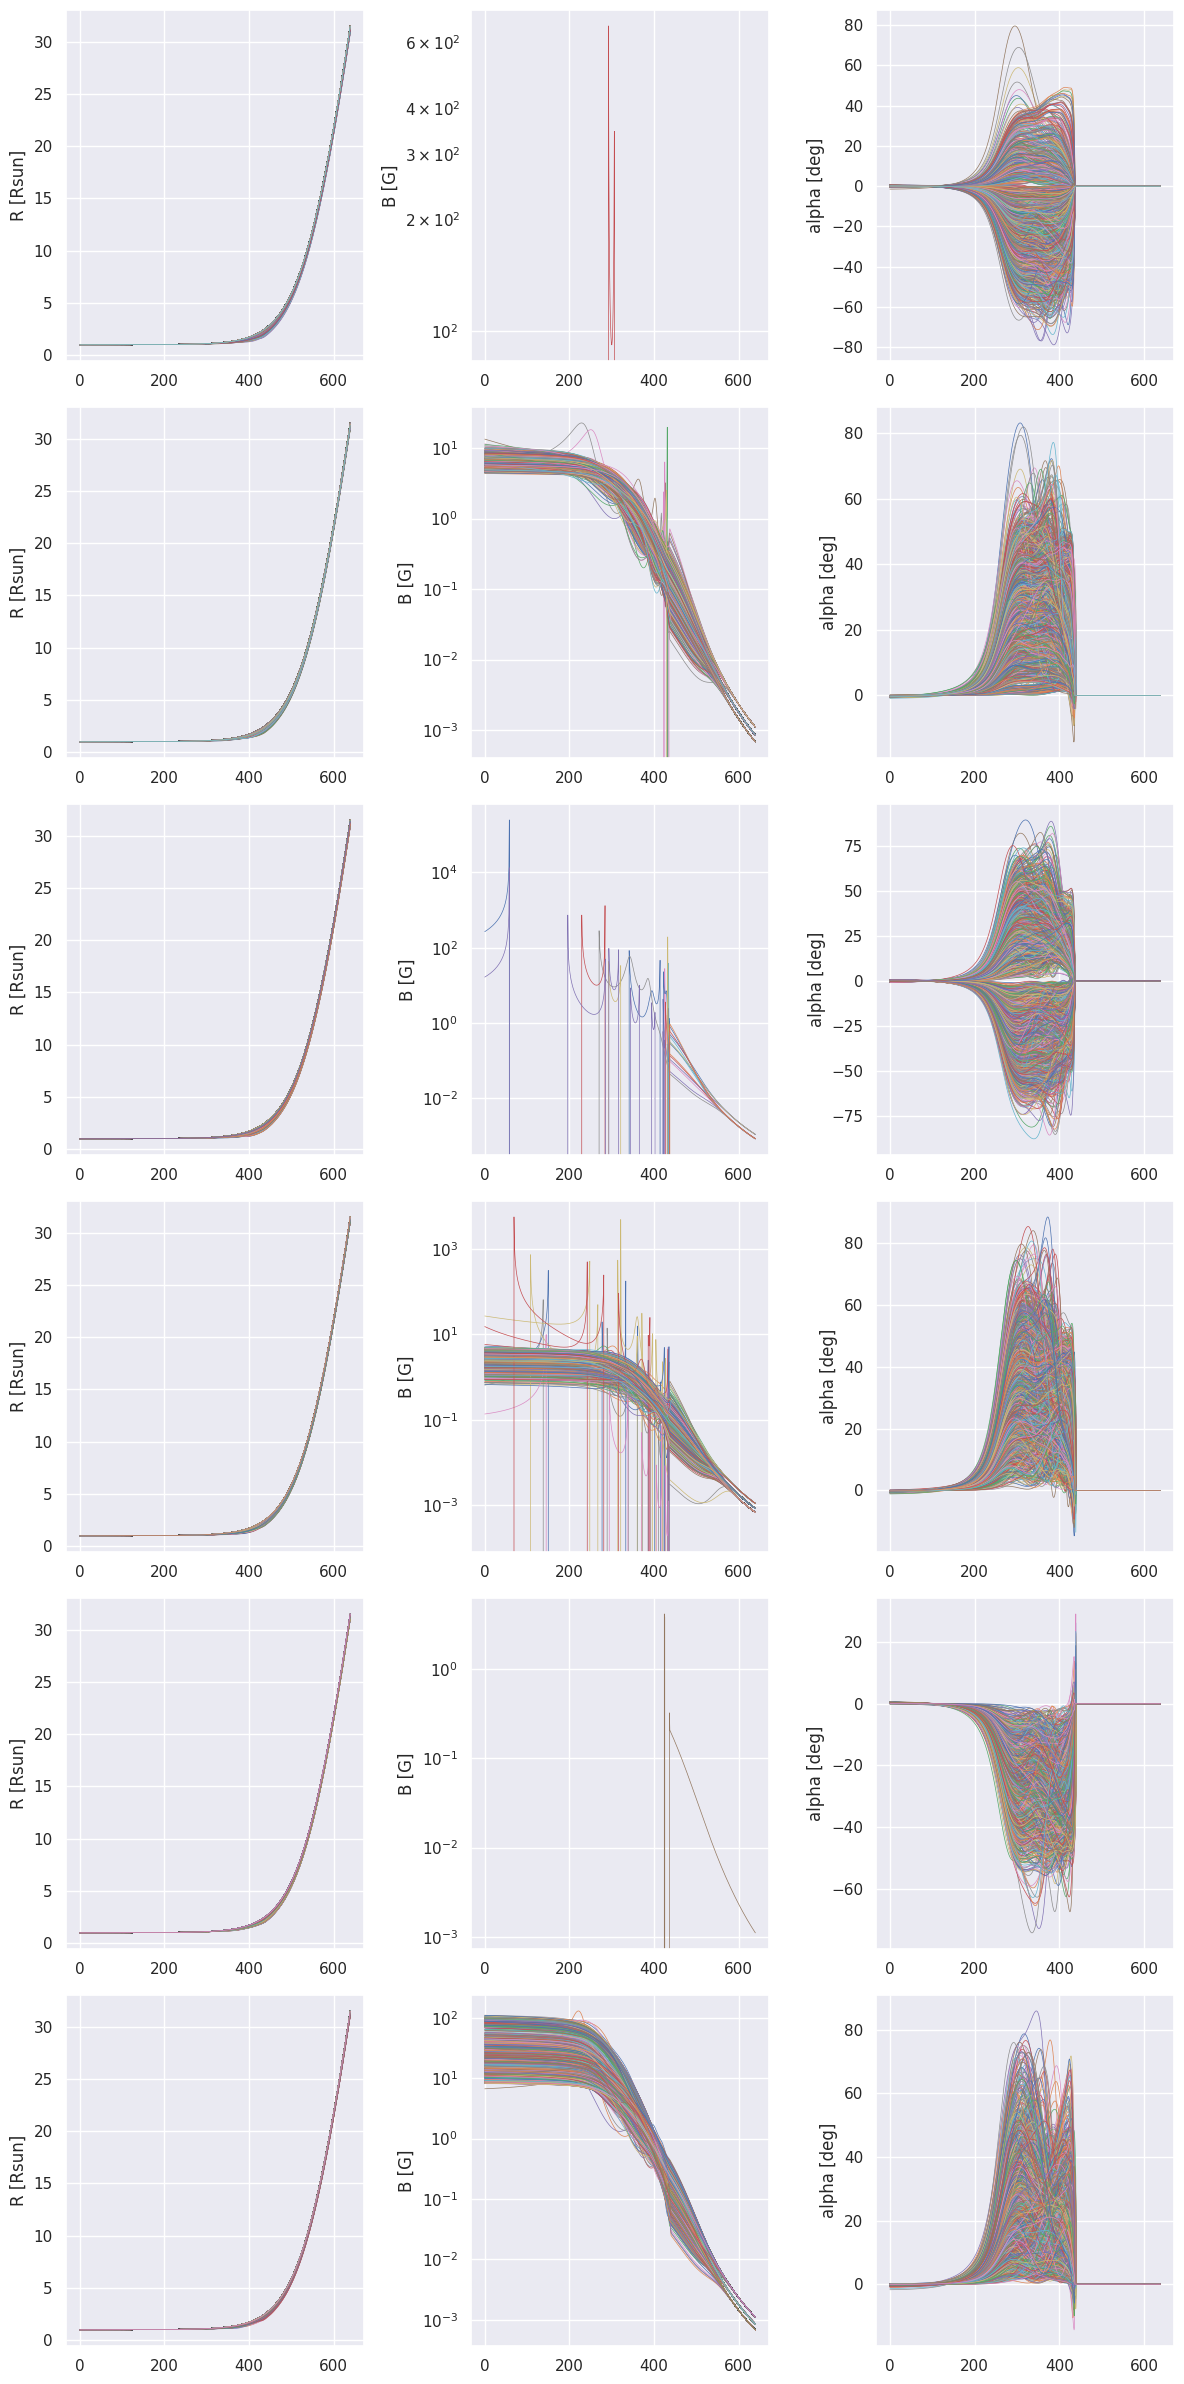

In [18]:
# display unscaled data into clusters
plot_unscaled_clusters(mag_labels, cluster_count, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

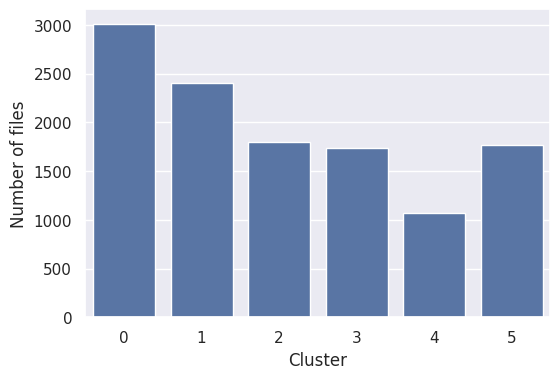

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))
bp = sns.countplot(x=mag_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

### Grid Search

In [23]:
%%capture
subdir = OUT_DIR / 'mag'
if not subdir.exists():
    subdir.mkdir()

for i in range(2, MAX_CLUSTERS):
    km = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=100, random_state=0)
    mag_labels = km.fit_predict(scaled_magnetic)
    plot_km_results(i, mag_labels, scaled_magnetic, save_path=subdir / 'kmeans_{}.png'.format(i))
    plot_unscaled_clusters(mag_labels, i, flows_dict, flow_columns, save_path=subdir / 'kmeans_{}_unscaled.png'.format(i), yscale={'B [G]': 'log'})

# Flux Tube Inclination - alpha [deg]

In [24]:
# separate into file series
scaled_alpha = [scaled_flows['alpha [deg]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['alpha [deg]']) // 640)]
scaled_alpha = np.array(scaled_alpha)
scaled_alpha[0][:5]


array([0.23913251, 0.23933345, 0.23958757, 0.23984632, 0.24010974])

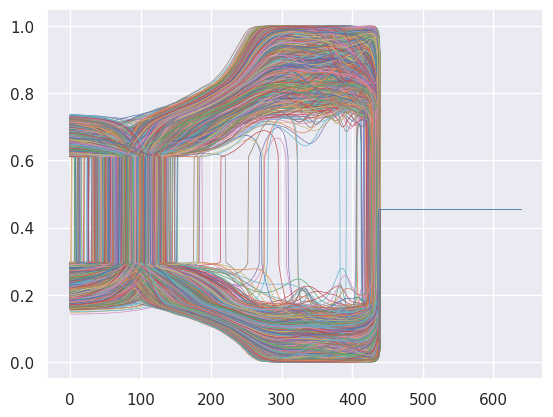

In [25]:
# plot scaled magnetic field
for a_line in scaled_alpha:
    plt.plot(a_line, linewidth=0.5)

plt.yscale('linear')

## K-Means

In [26]:
# rule of thumb number of clusters 
cluster_count = 4
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="euclidean", max_iter=500, random_state=0)
alpha_labels = km.fit_predict(scaled_alpha)

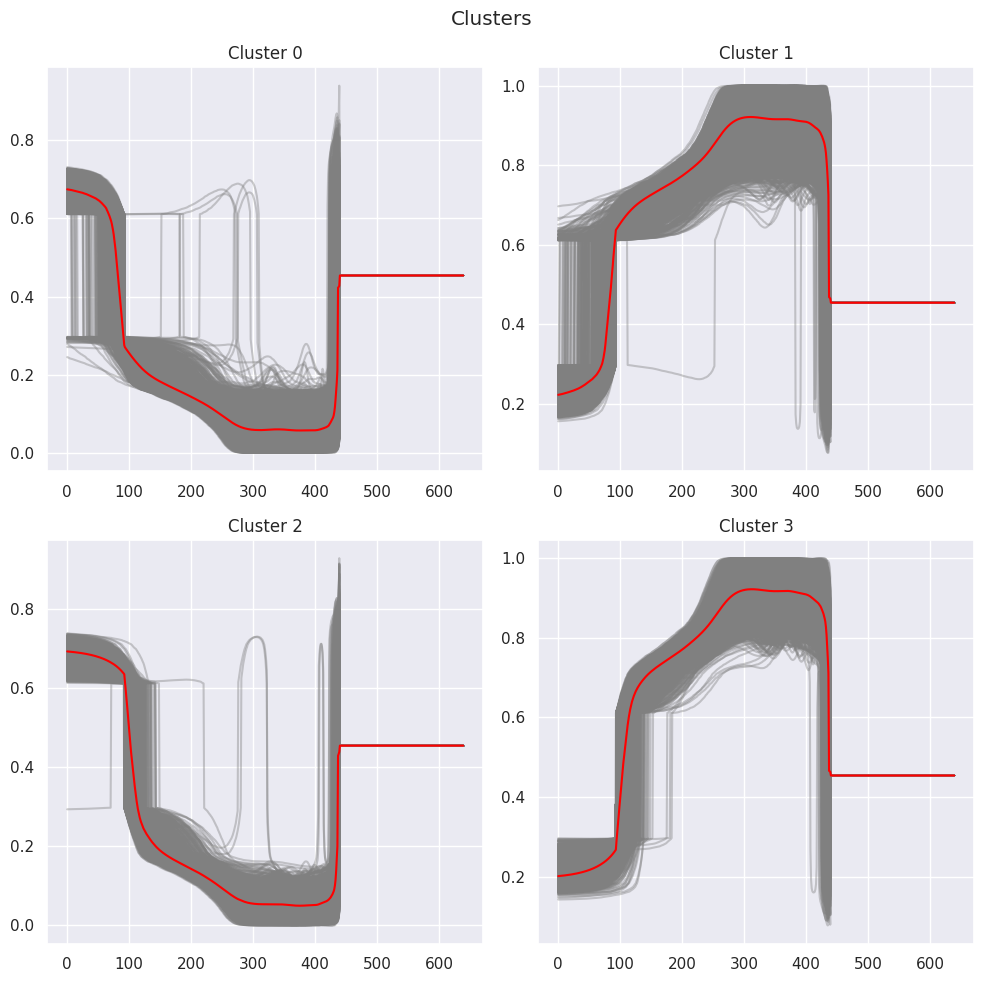

In [27]:
plot_km_results(cluster_count, alpha_labels, scaled_alpha)

### Original Data Clusters

/home/ivsaav/Projects/solarGAN/clustering/notebooks/tools.py:48: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[(labels[idx], col_pos)].set(ylabel=col, yscale=yscale.get(col, 'linear'))


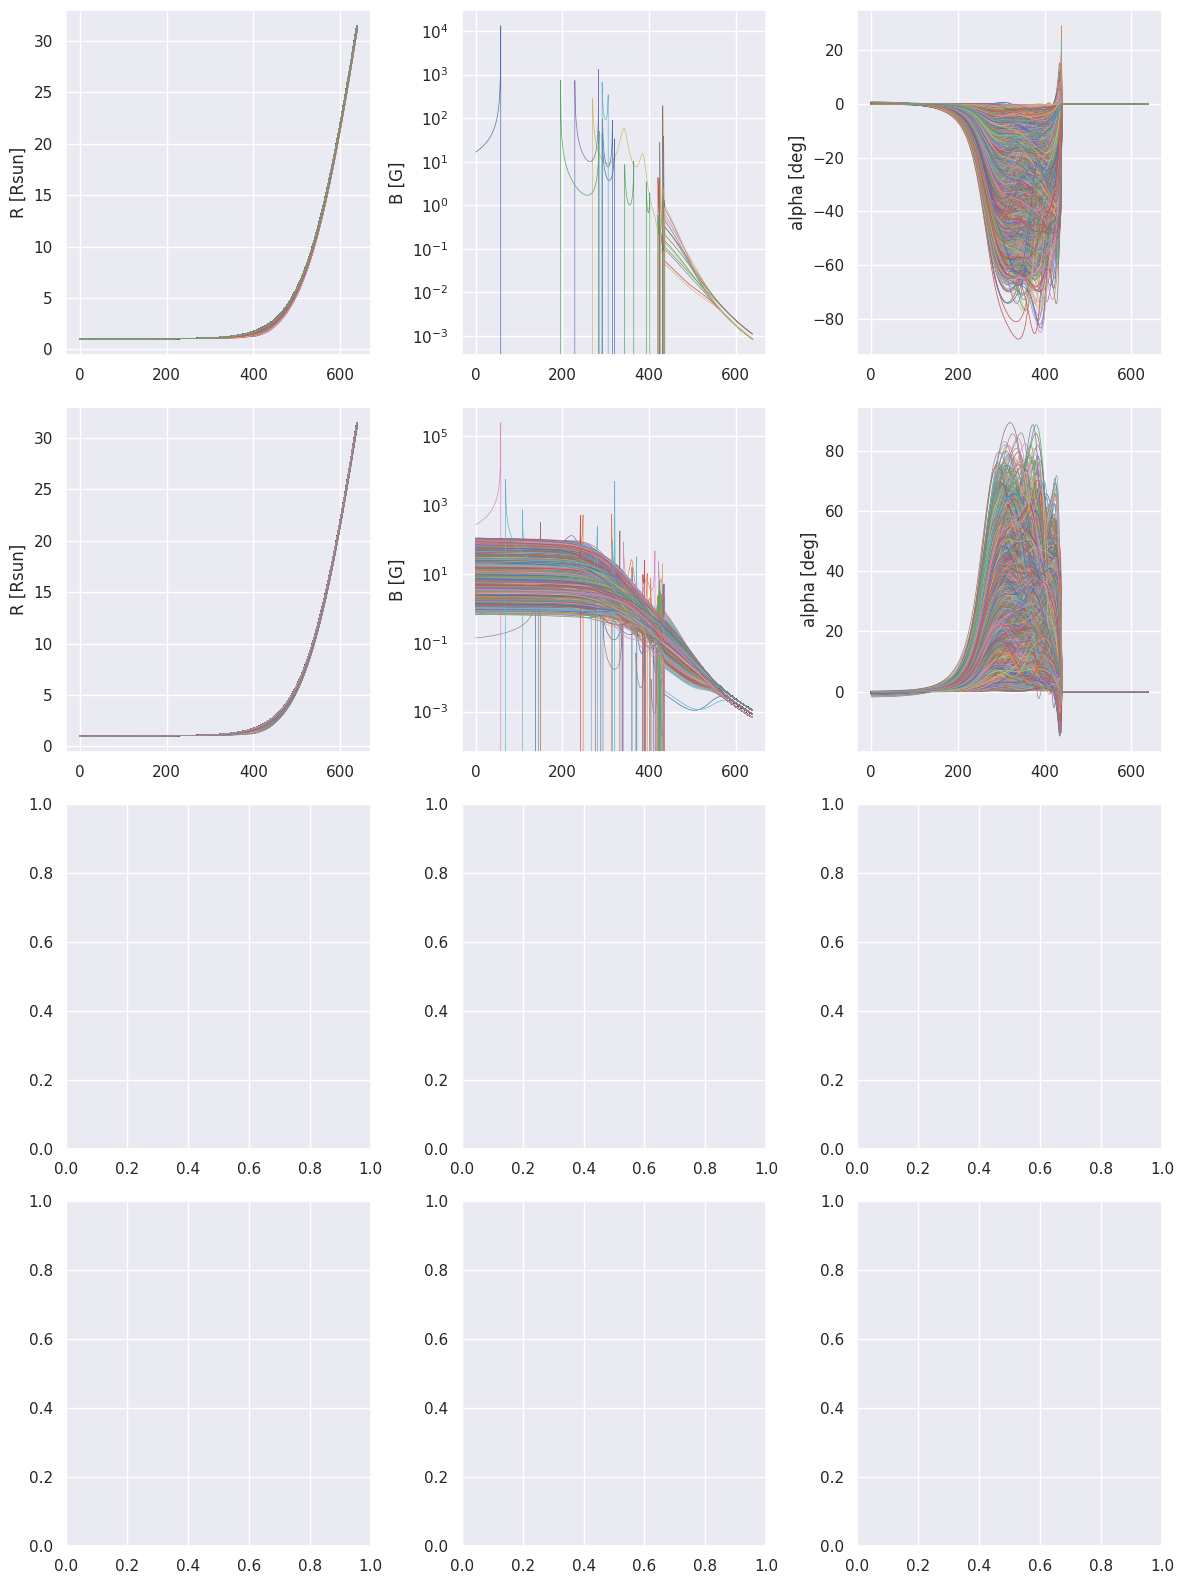

In [31]:
plot_unscaled_clusters(alpha_labels, cluster_count, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

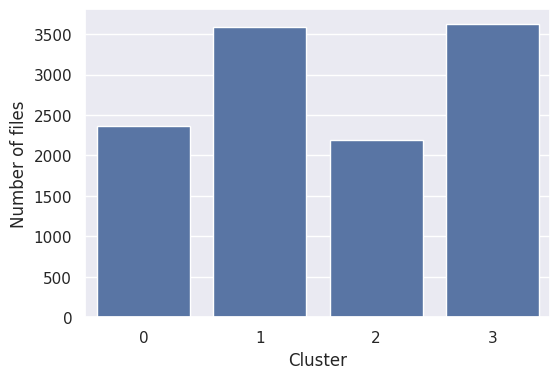

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))
bp = sns.countplot(x=alpha_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

### Grid Search

In [30]:
%%capture
subdir = OUT_DIR / 'alpha'
if not subdir.exists():
    subdir.mkdir()
    
for i in range(2, MAX_CLUSTERS):
    km = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=100, random_state=0)
    alpha_labels = km.fit_predict(scaled_alpha)
    plot_km_results(i, alpha_labels, scaled_alpha, save_path=subdir / 'kmeans_{}.png'.format(i))
    plot_unscaled_clusters(alpha_labels, i, flows_dict, flow_columns, save_path=subdir / 'kmeans_{}_unscaled.png'.format(i))

KeyboardInterrupt: 